In [1]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import missingno as msno

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

LOAD DATA

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
dict = pd.read_csv('../input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


PREPROCESS CSV

In [4]:
dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


<Axes: >

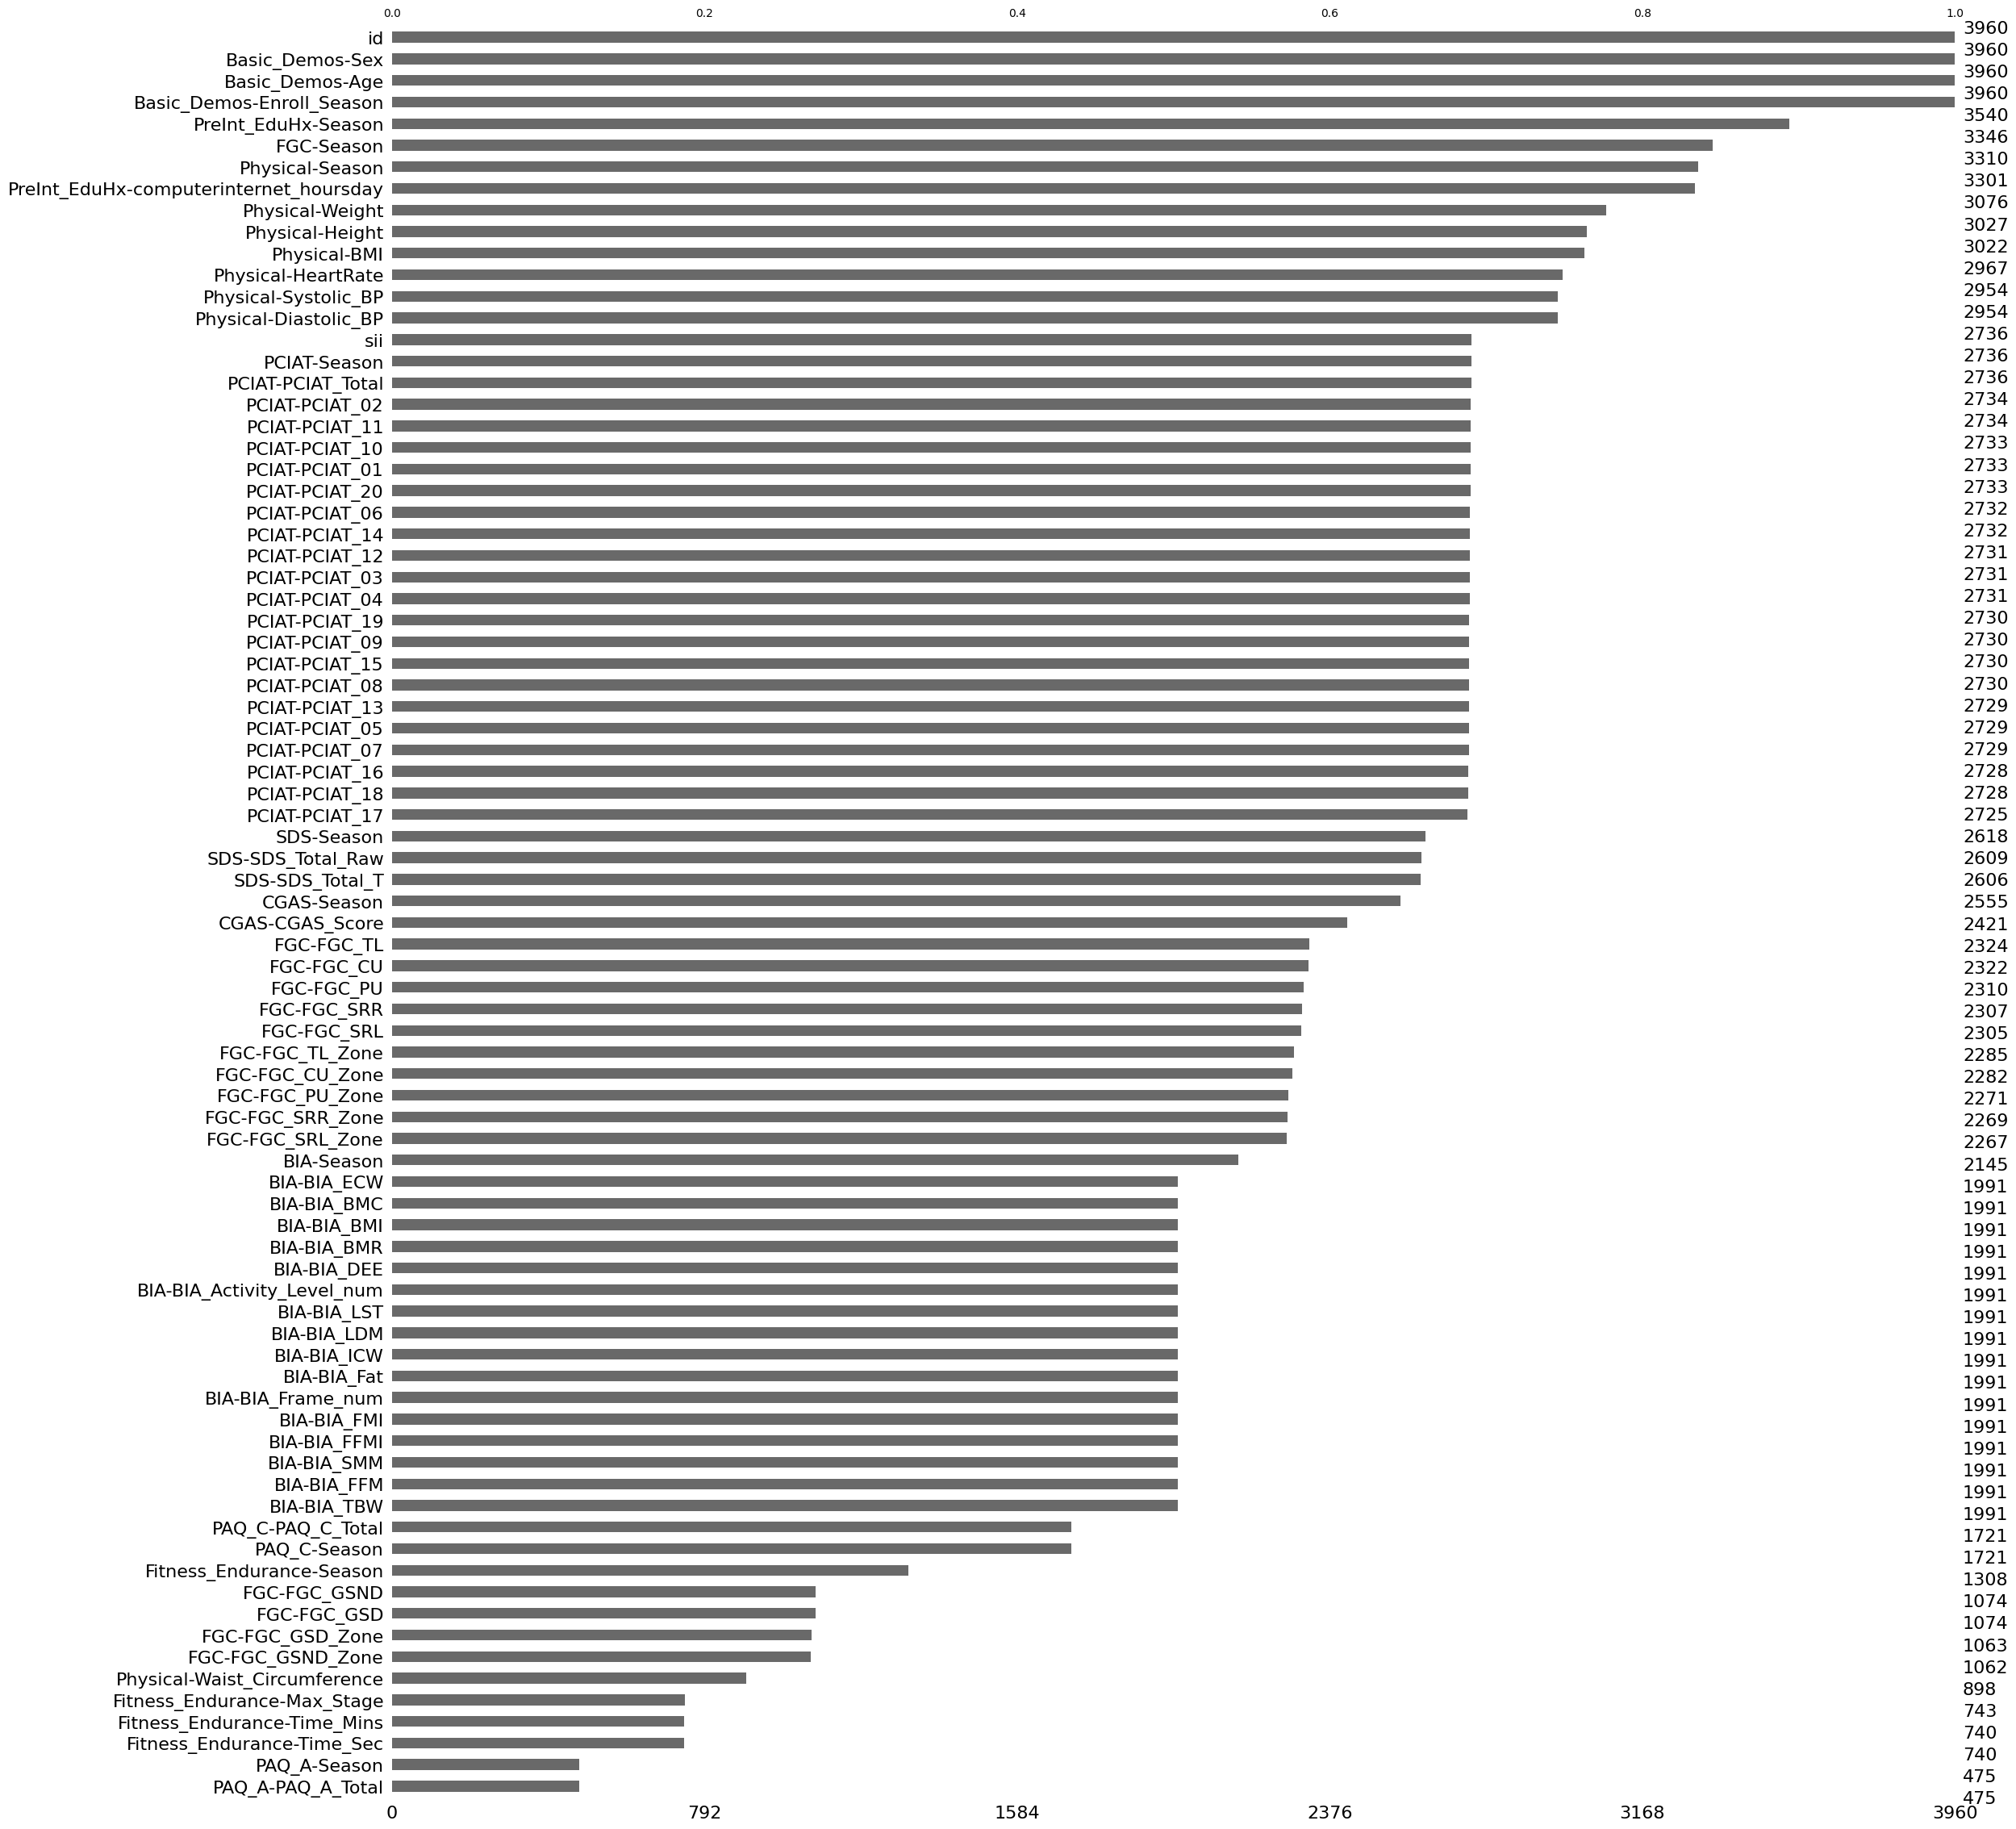

In [7]:
msno.bar(train.iloc[:, :train.shape[1]], sort='ascending')

<Axes: >

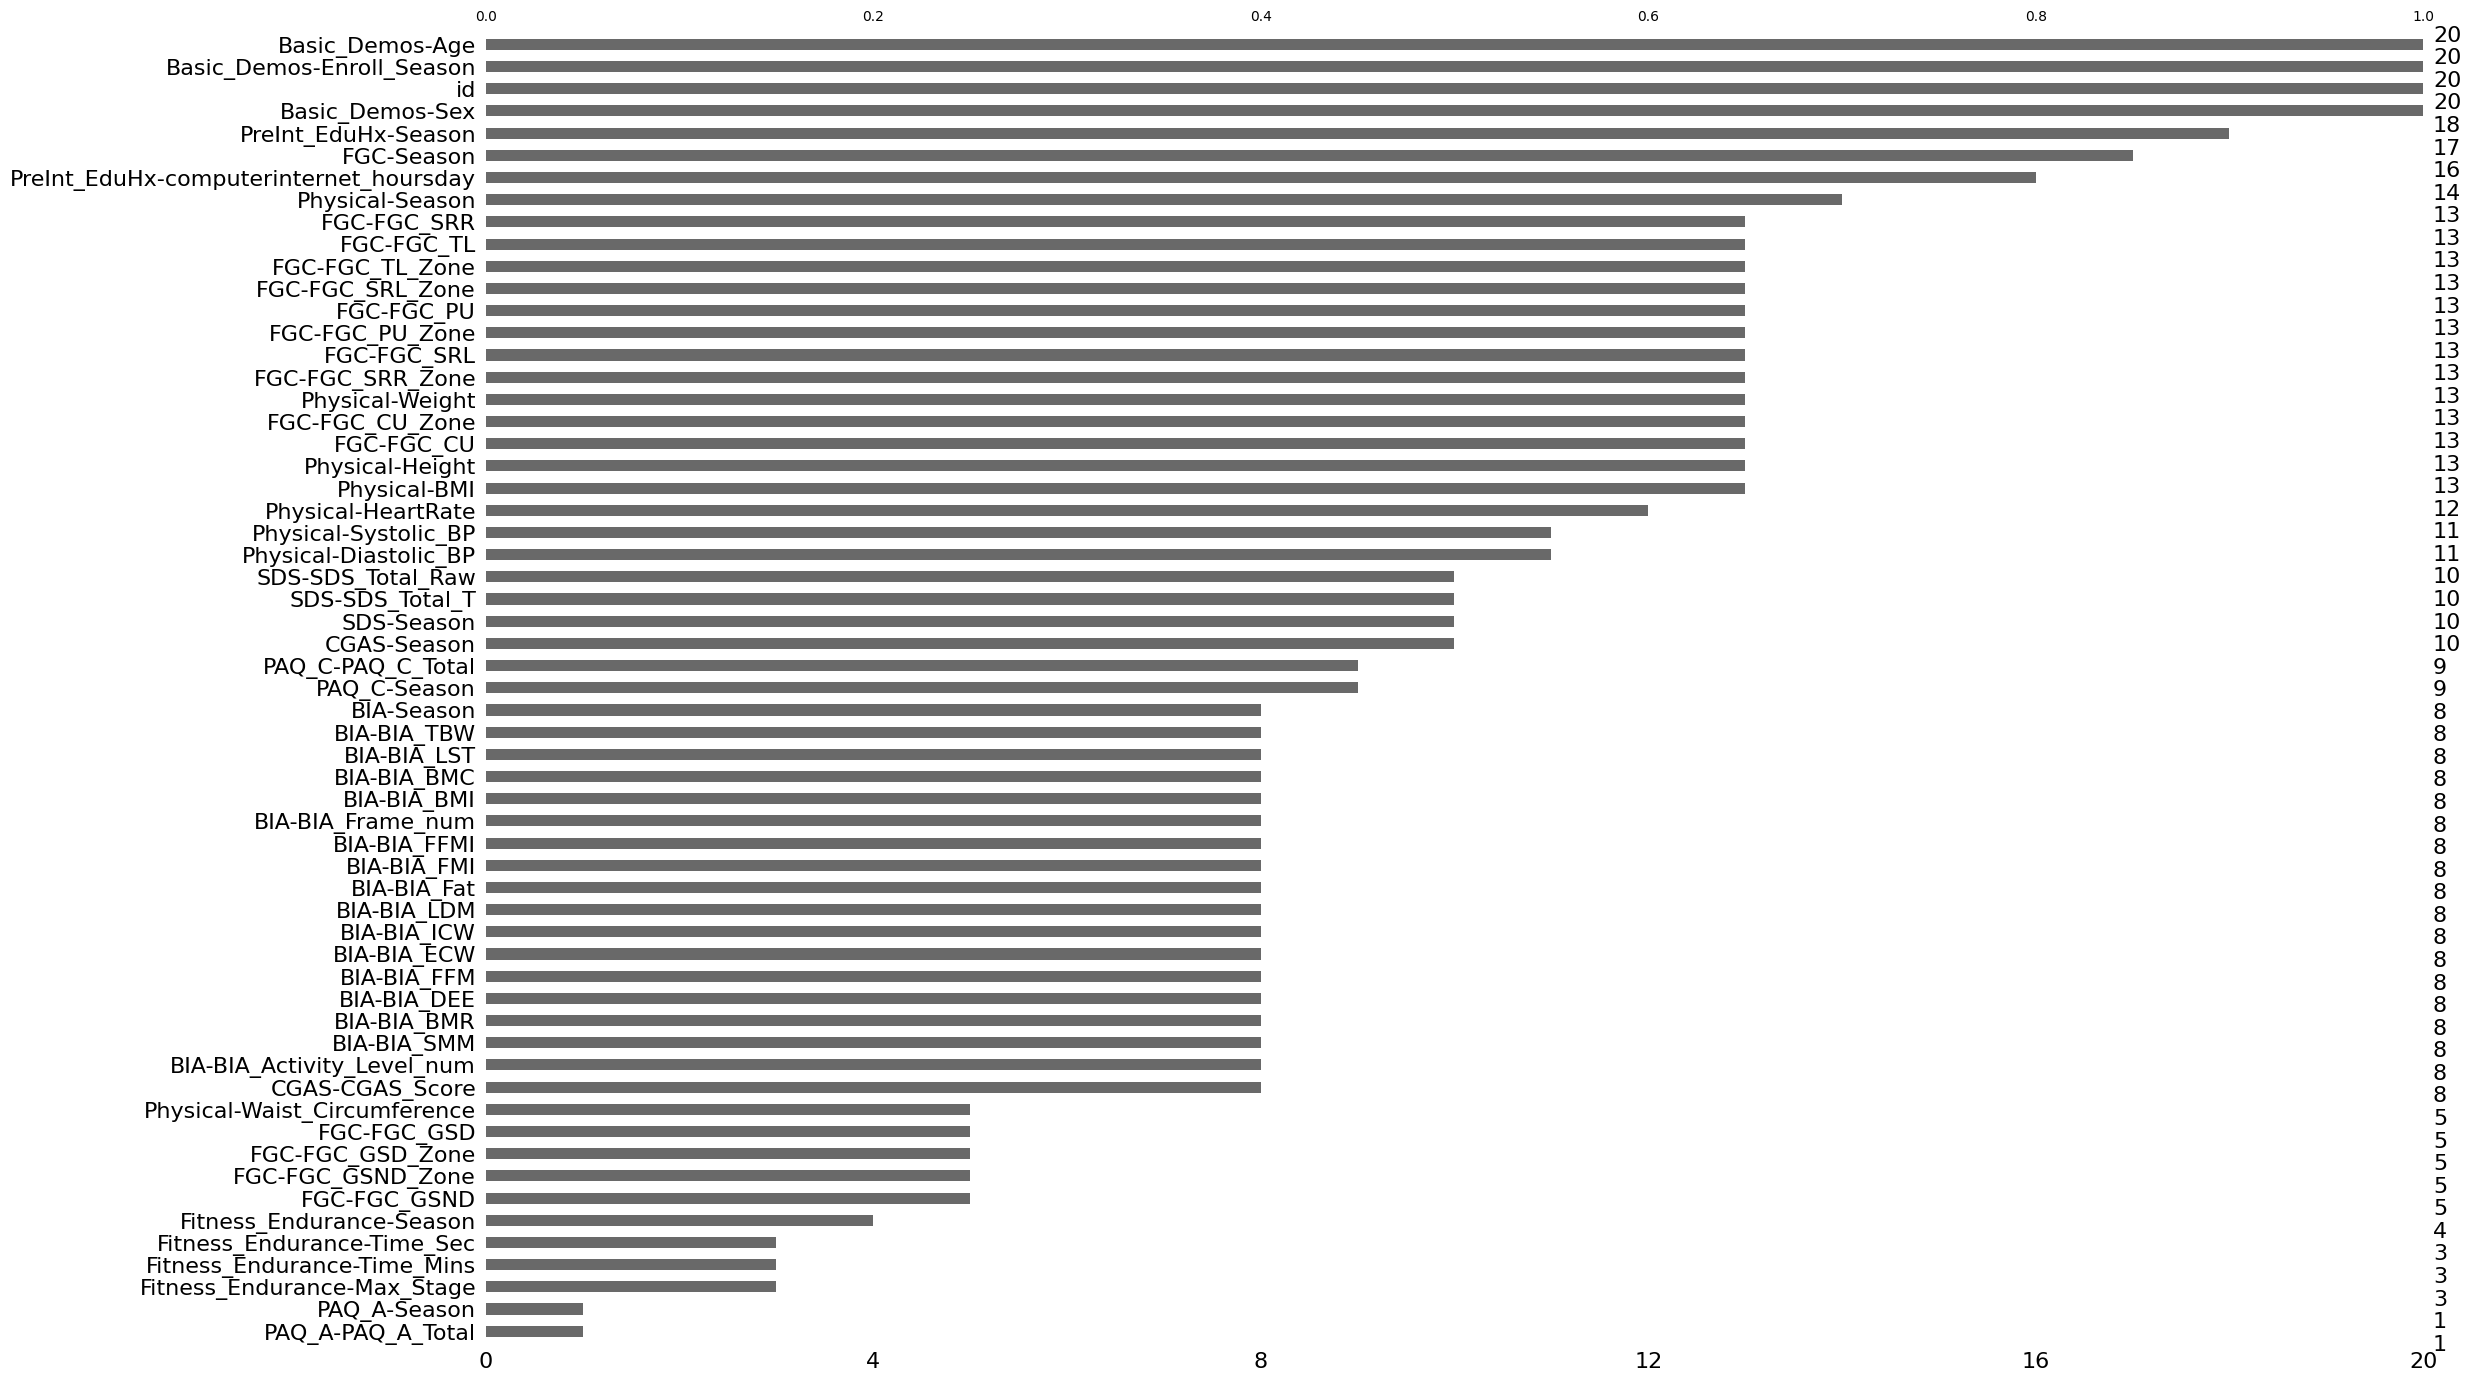

In [8]:
msno.bar(test.iloc[:, :test.shape[1]], sort='ascending')

In [9]:
column_not_in_test = set(train.columns) - set(test.columns)
column_not_in_test

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [10]:
feature_cols = train.columns.intersection(test.columns)
train_df = train[feature_cols]
train_df['sii'] = train['sii']
train = train_df
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [11]:
columns_in_train = pd.DataFrame({'Field': train.columns})

# Explain
train_dict= pd.merge(columns_in_train, dict, on='Field', how='left')
train_dict

,Field,Instrument,Description,Type,Values,Value Labels
0,id,Identifier,Participant's ID,str,NaN,NaN
1,Basic_Demos-Enroll_Season,Demographics,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Basic_Demos-Age,Demographics,Age of participant,float,NaN,NaN
3,Basic_Demos-Sex,Demographics,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,CGAS-Season,Children's Global Assessment Scale,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,CGAS-CGAS_Score,Children's Global Assessment Scale,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical-Season,Physical Measures,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical-BMI,Physical Measures,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical-Height,Physical Measures,Height (in),float,NaN,NaN
9,Physical-Weight,Physical Measures,Weight (lbs),float,NaN,NaN


In [12]:
train_no_id = train.drop(columns='id')

string_columns = train_no_id.select_dtypes(include=['object']).columns.tolist()
string_columns

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [13]:
# Drop season columns
train_no_id = train_no_id.drop(columns=string_columns)
train_no_id

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0
1,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0
2,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0
3,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0
4,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,13,0,60.0,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,3.260,35.0,50.0,1.0,1.0
3956,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,118.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.340,NaN,NaN,0.0,NaN
3957,11,0,68.0,21.441500,60.0,109.8,NaN,79.0,99.0,116.0,NaN,NaN,NaN,15.0,1.0,18.5,2.0,15.8,2.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.63952,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,NaN,2.729,56.0,77.0,0.0,1.0
3958,13,0,70.0,12.235895,70.7,87.0,NaN,59.0,61.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.66168,12.2372,1414.340,2970.12,26.53230,92.9092,13.0684,-0.83117,-5.90917,2.0,41.3715,25.00540,86.2475,45.4340,67.9038,NaN,3.300,33.0,47.0,1.0,0.0


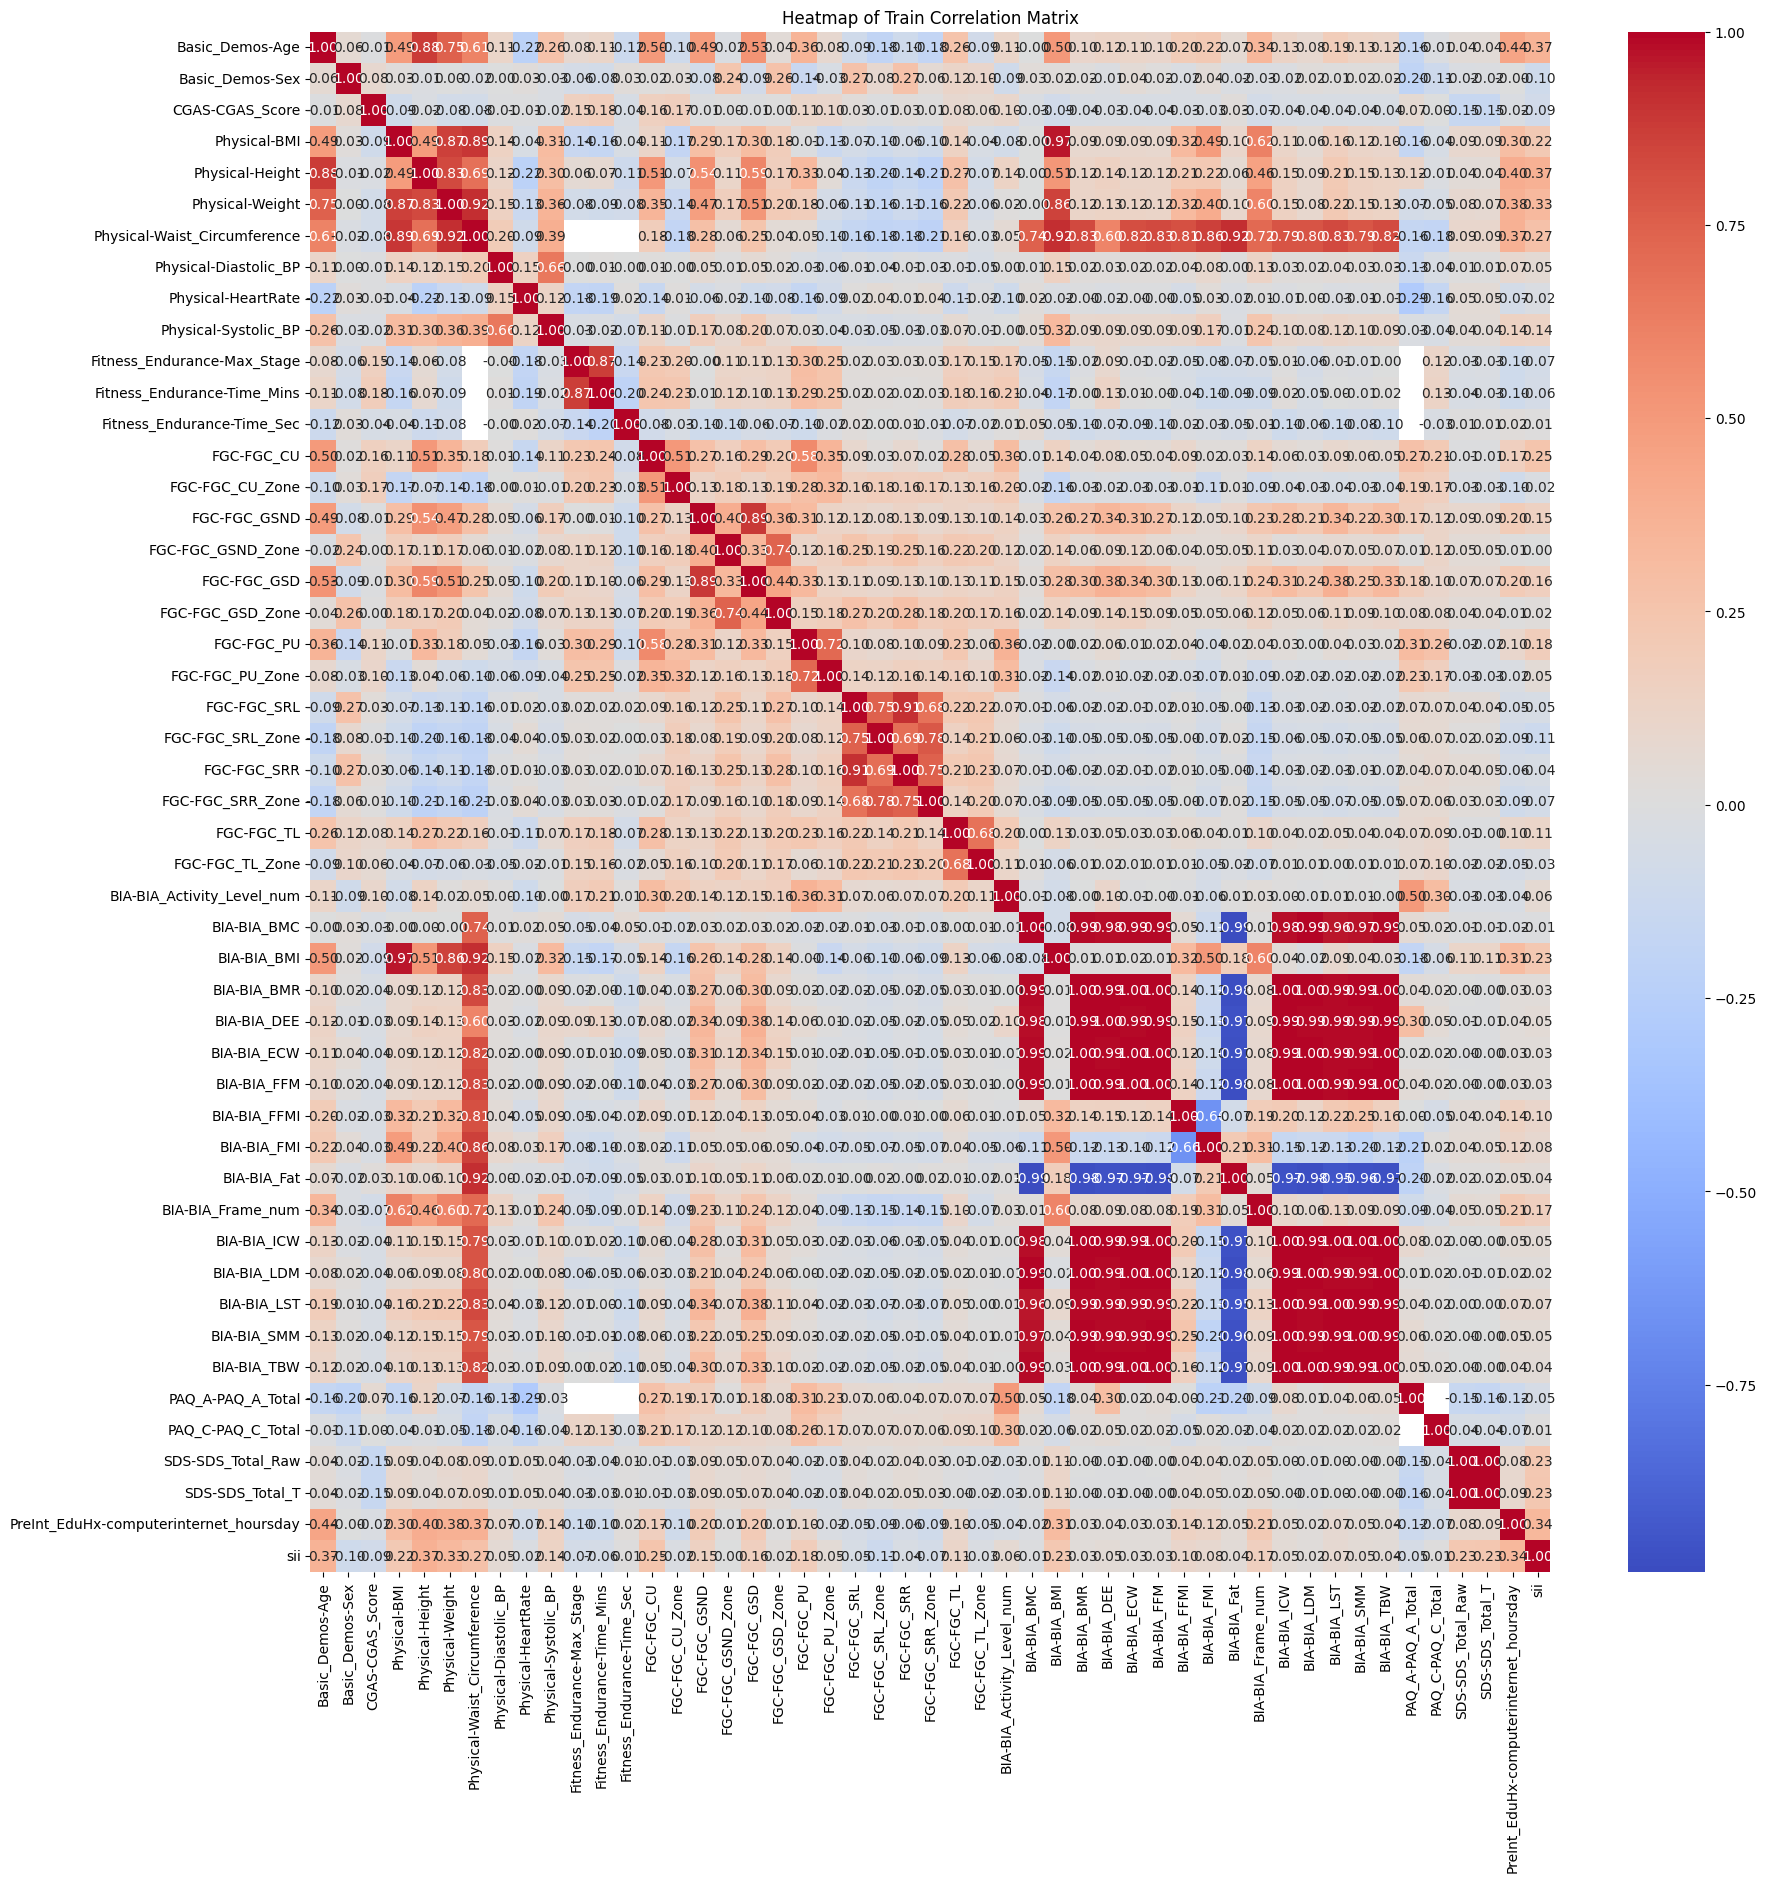

In [14]:
corr_train_matrix = train_no_id.corr()

# Vẽ heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Train Correlation Matrix")
plt.show()

In [15]:
def feature_engineering(df_):
    df = df_.copy()
    # Các chỉ số liên quan giữa thể chất và thời gian dùng internet
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Tỉ lệ lượng mỡ
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # Quan hệ giữa cơ và mỡ
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # Quan hệ giữa mỡ cơ thể và mỡ tổng thế
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # Tỷ lệ mô mềm và lượng nước
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # Mỡ * Tốc độ chuyển hóa
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # Mỡ * Mức năng lượng
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # Tỷ lệ BMR với cân nặng
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # Tỷ lệ tiêu thụ năng lượng và cân nặng
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # Tỷ lệ phát triển cơ bắp và chiều cao
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Tỷ lệ co bắp xương / cân nặng
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # Mức độ Hydrat hóa cơ thể
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

In [16]:
test_no_id = test.drop(columns='id')
test_no_id = test_no_id.drop(columns=string_columns)

In [17]:
test_no_id

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
0,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0
1,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0
2,10,1,71.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,5.0,7.0,33.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0
3,9,0,71.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,6.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0
4,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN
5,13,1,50.0,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,4.110,40.0,56.0,0.0
6,10,0,NaN,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,NaN,NaN,NaN,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.02590,59.4643,26.1957,47.2211,NaN,3.670,27.0,40.0,3.0
7,10,1,NaN,16.861286,59.25,84.2,27.0,71.0,90.0,116.0,NaN,NaN,NaN,0.0,0.0,12.6,2.0,11.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,4.05726,16.8631,1180.040,1888.06,21.94000,67.9527,13.6092,3.25395,16.24740,2.0,28.5367,17.47600,63.8954,28.7680,50.4767,NaN,1.270,NaN,NaN,2.0
8,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Sử dụng KNN
imputer = KNNImputer(n_neighbors=5)
numeric_cols_train = train_no_id.select_dtypes(include=['int32', 'int64', 'float64']).columns
numeric_cols_test = test_no_id.select_dtypes(include=['int32', 'int64', 'float64']).columns

imputed_data_train = imputer.fit_transform(train_no_id[numeric_cols_train])
imputed_data_test = imputer.fit_transform(test_no_id[numeric_cols_test])

train_imputed = pd.DataFrame(imputed_data_train, columns=numeric_cols_train)
test_imputed = pd.DataFrame(imputed_data_test, columns=numeric_cols_test)

train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train_no_id.columns:
    if col not in numeric_cols_train:
        train_imputed[col] = train_no_id[col]
for col in test_no_id.columns:
    if col not in numeric_cols_test:
        test_imputed[col] = test_no_id[col]

## Xử lý dữ liệu sau khi fill
train_df = train_imputed
test_df = test_imputed
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

In [19]:
train_df.replace([np.inf, -np.inf], 0, inplace=True)
test_df.replace([np.inf, -np.inf], 0, inplace=True)

TRAIN SIMPLE XGBOOST

In [20]:
## Hyperparameters
N_SPLITS = 5
SEED = 42

In [21]:
## Useful function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
    
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [22]:
## Train and get predict function
def train_predict(model, train_data, test_data):
    # Khớp giữ liệu input của train và test
    X = train_data.drop(columns=['sii'])
    y = train_data['sii']

    # Định nghĩa K-Fold
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    train_his = []
    val_his = []

    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), N_SPLITS))

    for fold, (train_index, val_index) in enumerate(tqdm(SKF.split(X, y), desc="Train progress", total = N_SPLITS)):
        # Xác định dữ liệu của fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Train
        model_ = clone(model) # tạo bản sao làm mới tại mỗi fold -> độc lập
        model_.fit(X_train, y_train)

        # Tính toán sai số
        y_train_pred = model_.predict(X_train)
        y_val_pred = model_.predict(X_val)

        oof_non_rounded[val_index] = y_val_pred
        y_train_pred_rounded = y_train_pred.round(0).astype(int)
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_index] = y_val_pred_rounded

        # Kiểm tra sai số giữa mô hình đánh giá và thực tế
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred_rounded)
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_his.append(train_kappa)
        val_his.append(val_kappa)

        test_preds[:, fold] = model_.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_his):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_his):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, model_, np.mean(val_his)

In [23]:
MODEL_BOUNDS = {
    'LightGBM': {
        'learning_rate': (0.01, 0.1),          # Từ rất thấp đến trung bình
        'max_depth': (6, 15),                 # Từ sâu vừa đến sâu hơn
        'num_leaves': (50, 500),              # Số lượng leaves lớn
        'min_data_in_leaf': (5, 50),          # Giới hạn dữ liệu tối thiểu
        'feature_fraction': (0.5, 1.0),       # Randomly select features
        'bagging_fraction': (0.5, 1.0),       # Randomly sample data
        'bagging_freq': (1, 10),              # Tần suất của bagging
        'lambda_l1': (0, 10),                 # Regularization L1
        'lambda_l2': (0, 10),                 # Regularization L2
    },
    'XGBoost': {
        'learning_rate': (0.01, 0.1),         # Học chậm để ổn định
        'max_depth': (3, 15),                 # Từ cây nông đến sâu
        'n_estimators': (50, 300),            # Số lượng cây
        'subsample': (0.5, 1.0),              # Tỷ lệ dữ liệu ngẫu nhiên
        'colsample_bytree': (0.5, 1.0),       # Tỷ lệ cột được chọn ngẫu nhiên
        'reg_alpha': (0, 10),                 # Regularization L1
        'reg_lambda': (0, 10),                # Regularization L2
    },
    'CatBoost': {
        'learning_rate': (0.01, 0.1),         # Tốc độ học
        'depth': (4, 10),                     # Độ sâu của cây
        'iterations': (100, 500),             # Số vòng lặp (iterations)
        'l2_leaf_reg': (1, 10),               # Regularization L2
    }
}

MUST_INT_PARAMS = {
    'LightGBM': ['max_depth', 'num_leaves', 'min_data_in_leaf', 'bagging_freq'],
    'XGBoost': ['max_depth', 'n_estimators'],
    'CatBoost': ['depth', 'iterations']
}

In [24]:
def bayesian_optimization(model: str):
    def objective(**args):
        params = args
        for key in MUST_INT_PARAMS[model]:
            params[key] = int(params[key])
            
        if model == 'LightGBM':
            model_instance = LGBMRegressor(**params, n_estimators=200, verbose=-1, random_state=SEED)
        elif model == 'XGBoost':
            model_instance = XGBRegressor(**params, tree_method='gpu_hist', random_state=SEED)
        elif model == 'CatBoost':
            model_instance = CatBoostRegressor(**params, task_type='GPU', verbose=0, random_seed=SEED)
        else:
            raise ValueError(f"Model {model} is not supported!")
            
        _,_, val_score = train_predict(model_instance, train_df, test_df)
        return -np.mean(val_score)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=MODEL_BOUNDS[model],
        random_state=SEED,
        verbose=-1
    )

    optimizer.maximize(init_points=20, n_iter=20)
    best_params = optimizer.max['params']
    for key in MUST_INT_PARAMS[model]:
        best_params[key] = int(best_params[key])

    return best_params

In [25]:
# Lấy tham số tối ưu từ hàm
XGBoost_params = bayesian_optimization('XGBoost')
# Tạo mô hình
XGBoost_Model = XGBRegressor(**XGBoost_params, tree_method='gpu_hist', random_state=SEED)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.52s/it]

Fold 1 - Train QWK: 0.9994, Validation QWK: 0.4883


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.28s/it]

Fold 2 - Train QWK: 0.9984, Validation QWK: 0.4237


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.21s/it]

Fold 3 - Train QWK: 0.9994, Validation QWK: 0.4352


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.18s/it]

Fold 4 - Train QWK: 0.9991, Validation QWK: 0.4087


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Fold 5 - Train QWK: 0.9991, Validation QWK: 0.4507
Mean Train QWK --> 0.9991
Mean Validation QWK ---> 0.4413
----> || Optimized QWK SCORE ::  0.481
| 1         | -0.4413   | 0.6873    | 0.09556   | 11.78     | 199.7     | 1.56      | 1.56      | 0.529     |


Train progress:  20%|██        | 1/5 [00:00<00:01,  3.54it/s]

Fold 1 - Train QWK: 0.6373, Validation QWK: 0.4515


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.64it/s]

Fold 2 - Train QWK: 0.6374, Validation QWK: 0.4405


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.65it/s]

Fold 3 - Train QWK: 0.6267, Validation QWK: 0.4343


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.66it/s]

Fold 4 - Train QWK: 0.6507, Validation QWK: 0.4258


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Fold 5 - Train QWK: 0.6339, Validation QWK: 0.4396
Mean Train QWK --> 0.6372
Mean Validation QWK ---> 0.4383
----> || Optimized QWK SCORE ::  0.499
| 2         | -0.4383   | 0.9331    | 0.0641    | 11.5      | 55.15     | 9.699     | 8.324     | 0.6062    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.18it/s]

Fold 1 - Train QWK: 0.6949, Validation QWK: 0.4456


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.20it/s]

Fold 2 - Train QWK: 0.7003, Validation QWK: 0.4496


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.20it/s]

Fold 3 - Train QWK: 0.7085, Validation QWK: 0.4555


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.19it/s]

Fold 4 - Train QWK: 0.7099, Validation QWK: 0.4520


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Fold 5 - Train QWK: 0.6915, Validation QWK: 0.4534
Mean Train QWK --> 0.7010
Mean Validation QWK ---> 0.4512
----> || Optimized QWK SCORE ::  0.504
| 3         | -0.4512   | 0.5909    | 0.02651   | 6.651     | 181.2     | 4.319     | 2.912     | 0.8059    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.98it/s]

Fold 1 - Train QWK: 0.7118, Validation QWK: 0.4456


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Fold 2 - Train QWK: 0.7031, Validation QWK: 0.4486


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Train QWK: 0.7044, Validation QWK: 0.4355


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Fold 4 - Train QWK: 0.7063, Validation QWK: 0.4528


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Fold 5 - Train QWK: 0.7096, Validation QWK: 0.4681
Mean Train QWK --> 0.7070
Mean Validation QWK ---> 0.4501
----> || Optimized QWK SCORE ::  0.508
| 4         | -0.4501   | 0.5697    | 0.03629   | 7.396     | 164.0     | 7.852     | 1.997     | 0.7571    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.19it/s]

Fold 1 - Train QWK: 0.7329, Validation QWK: 0.4625


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.22it/s]

Fold 2 - Train QWK: 0.7312, Validation QWK: 0.3656


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

Fold 3 - Train QWK: 0.7306, Validation QWK: 0.3982


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

Fold 4 - Train QWK: 0.7480, Validation QWK: 0.4235


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Fold 5 - Train QWK: 0.7317, Validation QWK: 0.3974
Mean Train QWK --> 0.7349
Mean Validation QWK ---> 0.4094
----> || Optimized QWK SCORE ::  0.433
| 5         | -0.4094   | 0.7962    | 0.01418   | 10.29     | 92.63     | 0.6505    | 9.489     | 0.9828    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.84it/s]

Fold 1 - Train QWK: 0.6310, Validation QWK: 0.4581


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.85it/s]

Fold 2 - Train QWK: 0.6416, Validation QWK: 0.4353


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

Fold 3 - Train QWK: 0.6422, Validation QWK: 0.4486


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.85it/s]

Fold 4 - Train QWK: 0.6451, Validation QWK: 0.4548


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Fold 5 - Train QWK: 0.6315, Validation QWK: 0.4690
Mean Train QWK --> 0.6383
Mean Validation QWK ---> 0.4532
----> || Optimized QWK SCORE ::  0.502
| 6         | -0.4532   | 0.9042    | 0.03742   | 4.172     | 221.1     | 4.402     | 1.22      | 0.7476    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.88it/s]

Fold 1 - Train QWK: 0.9464, Validation QWK: 0.5035


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.90it/s]

Fold 2 - Train QWK: 0.9425, Validation QWK: 0.4369


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

Fold 3 - Train QWK: 0.9378, Validation QWK: 0.4404


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Fold 4 - Train QWK: 0.9411, Validation QWK: 0.4386


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Fold 5 - Train QWK: 0.9407, Validation QWK: 0.4702
Mean Train QWK --> 0.9417
Mean Validation QWK ---> 0.4579
----> || Optimized QWK SCORE ::  0.486
| 7         | -0.4579   | 0.5172    | 0.09184   | 6.105     | 215.6     | 3.117     | 5.201     | 0.7734    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.07it/s]

Fold 1 - Train QWK: 0.9369, Validation QWK: 0.4863


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.07it/s]

Fold 2 - Train QWK: 0.9399, Validation QWK: 0.4369


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

Fold 3 - Train QWK: 0.9320, Validation QWK: 0.4295


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.06it/s]

Fold 4 - Train QWK: 0.9382, Validation QWK: 0.4408


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Fold 5 - Train QWK: 0.9332, Validation QWK: 0.4766
Mean Train QWK --> 0.9360
Mean Validation QWK ---> 0.4541
----> || Optimized QWK SCORE ::  0.493
| 8         | -0.4541   | 0.5924    | 0.09726   | 12.3      | 284.9     | 8.948     | 5.979     | 0.9609    |


Train progress:  40%|████      | 2/5 [00:00<00:00,  5.03it/s]

Fold 1 - Train QWK: 0.4511, Validation QWK: 0.4237
Fold 2 - Train QWK: 0.4689, Validation QWK: 0.3722


Train progress:  80%|████████  | 4/5 [00:00<00:00,  5.07it/s]

Fold 3 - Train QWK: 0.4528, Validation QWK: 0.3977
Fold 4 - Train QWK: 0.4613, Validation QWK: 0.4103


Train progress: 100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Fold 5 - Train QWK: 0.4538, Validation QWK: 0.4155
Mean Train QWK --> 0.4576
Mean Validation QWK ---> 0.4039
----> || Optimized QWK SCORE ::  0.429
| 9         | -0.4039   | 0.5442    | 0.02764   | 3.543     | 131.3     | 3.887     | 2.713     | 0.9144    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Fold 1 - Train QWK: 0.6875, Validation QWK: 0.4558


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.57it/s]

Fold 2 - Train QWK: 0.6998, Validation QWK: 0.4298


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

Fold 3 - Train QWK: 0.6828, Validation QWK: 0.4354


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

Fold 4 - Train QWK: 0.6871, Validation QWK: 0.4320


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Fold 5 - Train QWK: 0.6739, Validation QWK: 0.4467
Mean Train QWK --> 0.6862
Mean Validation QWK ---> 0.4399
----> || Optimized QWK SCORE ::  0.508
| 10        | -0.4399   | 0.6784    | 0.03528   | 9.512     | 85.23     | 8.022     | 0.7455    | 0.9934    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  3.02it/s]

Fold 1 - Train QWK: 0.5125, Validation QWK: 0.4588


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.02it/s]

Fold 2 - Train QWK: 0.5218, Validation QWK: 0.4048


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.84it/s]

Fold 3 - Train QWK: 0.5089, Validation QWK: 0.4303


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.91it/s]

Fold 4 - Train QWK: 0.5247, Validation QWK: 0.4143


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Fold 5 - Train QWK: 0.5119, Validation QWK: 0.4535
Mean Train QWK --> 0.5160
Mean Validation QWK ---> 0.4323
----> || Optimized QWK SCORE ::  0.506
| 11        | -0.4323   | 0.8861    | 0.02788   | 3.066     | 253.9     | 7.069     | 7.29      | 0.8856    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.43it/s]

Fold 1 - Train QWK: 0.6207, Validation QWK: 0.4527


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.44it/s]

Fold 2 - Train QWK: 0.6327, Validation QWK: 0.4437


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.45it/s]

Fold 3 - Train QWK: 0.6122, Validation QWK: 0.4504


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.45it/s]

Fold 4 - Train QWK: 0.6268, Validation QWK: 0.4418


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Fold 5 - Train QWK: 0.6271, Validation QWK: 0.4798
Mean Train QWK --> 0.6239
Mean Validation QWK ---> 0.4537
----> || Optimized QWK SCORE ::  0.504
| 12        | -0.4537   | 0.537     | 0.04226   | 4.39      | 265.8     | 6.233     | 3.309     | 0.5318    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]

Fold 1 - Train QWK: 0.7630, Validation QWK: 0.4707


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.22it/s]

Fold 2 - Train QWK: 0.7636, Validation QWK: 0.4489


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

Fold 3 - Train QWK: 0.7677, Validation QWK: 0.4649


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

Fold 4 - Train QWK: 0.7777, Validation QWK: 0.4696


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Fold 5 - Train QWK: 0.7742, Validation QWK: 0.4825
Mean Train QWK --> 0.7692
Mean Validation QWK ---> 0.4673
----> || Optimized QWK SCORE ::  0.476
| 13        | -0.4673   | 0.6555    | 0.03927   | 11.76     | 209.4     | 8.872     | 4.722     | 0.5598    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.07it/s]

Fold 1 - Train QWK: 0.9699, Validation QWK: 0.4916


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.09it/s]

Fold 2 - Train QWK: 0.9709, Validation QWK: 0.4195


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

Fold 3 - Train QWK: 0.9680, Validation QWK: 0.4362


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.08it/s]

Fold 4 - Train QWK: 0.9672, Validation QWK: 0.4775


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Fold 5 - Train QWK: 0.9683, Validation QWK: 0.4847
Mean Train QWK --> 0.9688
Mean Validation QWK ---> 0.4619
----> || Optimized QWK SCORE ::  0.493
| 14        | -0.4619   | 0.8566    | 0.07847   | 9.735     | 242.7     | 4.938     | 5.227     | 0.7138    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  3.53it/s]

Fold 1 - Train QWK: 0.4609, Validation QWK: 0.4170


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.56it/s]

Fold 2 - Train QWK: 0.4728, Validation QWK: 0.3722


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.56it/s]

Fold 3 - Train QWK: 0.4595, Validation QWK: 0.4046


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.56it/s]

Fold 4 - Train QWK: 0.4843, Validation QWK: 0.4210


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Fold 5 - Train QWK: 0.4635, Validation QWK: 0.4269
Mean Train QWK --> 0.4682
Mean Validation QWK ---> 0.4083
----> || Optimized QWK SCORE ::  0.507
| 15        | -0.4083   | 0.5127    | 0.01971   | 3.377     | 209.1     | 3.144     | 5.086     | 0.9538    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.00it/s]

Fold 1 - Train QWK: 0.9668, Validation QWK: 0.4588


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.04it/s]

Fold 2 - Train QWK: 0.9669, Validation QWK: 0.4419


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.03it/s]

Fold 3 - Train QWK: 0.9668, Validation QWK: 0.4442


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.03it/s]

Fold 4 - Train QWK: 0.9650, Validation QWK: 0.4509


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Fold 5 - Train QWK: 0.9654, Validation QWK: 0.4501
Mean Train QWK --> 0.9662
Mean Validation QWK ---> 0.4492
----> || Optimized QWK SCORE ::  0.491
| 16        | -0.4492   | 0.6246    | 0.04693   | 12.07     | 107.2     | 0.7698    | 2.898     | 0.5806    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.09it/s]

Fold 1 - Train QWK: 0.9525, Validation QWK: 0.4735


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.08it/s]

Fold 2 - Train QWK: 0.9586, Validation QWK: 0.4291


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.10it/s]

Fold 3 - Train QWK: 0.9547, Validation QWK: 0.4276


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Fold 4 - Train QWK: 0.9546, Validation QWK: 0.4552


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Fold 5 - Train QWK: 0.9545, Validation QWK: 0.4679
Mean Train QWK --> 0.9550
Mean Validation QWK ---> 0.4507
----> || Optimized QWK SCORE ::  0.483
| 17        | -0.4507   | 0.9648    | 0.08273   | 10.6      | 267.9     | 8.037     | 1.866     | 0.9463    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.21s/it]

Fold 1 - Train QWK: 0.9997, Validation QWK: 0.4563


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.20s/it]

Fold 2 - Train QWK: 0.9994, Validation QWK: 0.3885


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.21s/it]

Fold 3 - Train QWK: 0.9997, Validation QWK: 0.4421


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.20s/it]

Fold 4 - Train QWK: 1.0000, Validation QWK: 0.4167


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Fold 5 - Train QWK: 0.9997, Validation QWK: 0.4631
Mean Train QWK --> 0.9997
Mean Validation QWK ---> 0.4333
----> || Optimized QWK SCORE ::  0.473
| 18        | -0.4333   | 0.7697    | 0.08267   | 13.75     | 129.5     | 1.101     | 2.279     | 0.7136    |


Train progress:  20%|██        | 1/5 [00:00<00:00,  4.02it/s]

Fold 1 - Train QWK: 0.6027, Validation QWK: 0.4871


Train progress:  40%|████      | 2/5 [00:00<00:00,  4.03it/s]

Fold 2 - Train QWK: 0.6260, Validation QWK: 0.4225


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.90it/s]

Fold 3 - Train QWK: 0.6162, Validation QWK: 0.4453


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.66it/s]

Fold 4 - Train QWK: 0.6078, Validation QWK: 0.4417


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


Fold 5 - Train QWK: 0.6229, Validation QWK: 0.4649
Mean Train QWK --> 0.6151
Mean Validation QWK ---> 0.4523
----> || Optimized QWK SCORE ::  0.511
| 19        | -0.4523   | 0.909     | 0.08747   | 3.083     | 177.7     | 4.174     | 2.221     | 0.5599    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.23it/s]

Fold 1 - Train QWK: 0.8630, Validation QWK: 0.4900


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.26it/s]

Fold 2 - Train QWK: 0.8589, Validation QWK: 0.4375


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.26it/s]

Fold 3 - Train QWK: 0.8588, Validation QWK: 0.4502


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.27it/s]

Fold 4 - Train QWK: 0.8689, Validation QWK: 0.4781


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

Fold 5 - Train QWK: 0.8659, Validation QWK: 0.4822
Mean Train QWK --> 0.8631
Mean Validation QWK ---> 0.4676
----> || Optimized QWK SCORE ::  0.505
| 20        | -0.4676   | 0.6688    | 0.09486   | 6.878     | 179.7     | 7.03      | 3.636     | 0.9859    |



Train progress:  20%|██        | 1/5 [00:00<00:00,  4.20it/s]

Fold 1 - Train QWK: 0.6175, Validation QWK: 0.4561


Train progress:  40%|████      | 2/5 [00:00<00:00,  4.20it/s]

Fold 2 - Train QWK: 0.6246, Validation QWK: 0.4479


Train progress:  60%|██████    | 3/5 [00:00<00:00,  4.29it/s]

Fold 3 - Train QWK: 0.6173, Validation QWK: 0.4573


Train progress:  80%|████████  | 4/5 [00:00<00:00,  4.30it/s]

Fold 4 - Train QWK: 0.6253, Validation QWK: 0.4400


Train progress: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Fold 5 - Train QWK: 0.6358, Validation QWK: 0.4635
Mean Train QWK --> 0.6241
Mean Validation QWK ---> 0.4530
----> || Optimized QWK SCORE ::  0.504
| 21        | -0.453    | 0.8162    | 0.06337   | 4.449     | 131.5     | 5.63      | 1.872     | 0.9003    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.46s/it]

Fold 1 - Train QWK: 0.7793, Validation QWK: 0.4807


Train progress:  40%|████      | 2/5 [00:02<00:04,  1.42s/it]

Fold 2 - Train QWK: 0.7825, Validation QWK: 0.4566


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.41s/it]

Fold 3 - Train QWK: 0.7852, Validation QWK: 0.4609


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.41s/it]

Fold 4 - Train QWK: 0.7898, Validation QWK: 0.4524


Train progress: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]

Fold 5 - Train QWK: 0.7846, Validation QWK: 0.4747
Mean Train QWK --> 0.7843
Mean Validation QWK ---> 0.4651
----> || Optimized QWK SCORE ::  0.510
| 22        | -0.4651   | 0.5322    | 0.01981   | 13.76     | 262.5     | 7.519     | 2.789     | 0.7489    |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.11it/s]

Fold 1 - Train QWK: 0.8150, Validation QWK: 0.4781


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.15it/s]

Fold 2 - Train QWK: 0.8141, Validation QWK: 0.4537


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.16it/s]

Fold 3 - Train QWK: 0.8152, Validation QWK: 0.4546


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.16it/s]

Fold 4 - Train QWK: 0.8150, Validation QWK: 0.4746


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Fold 5 - Train QWK: 0.8168, Validation QWK: 0.4772
Mean Train QWK --> 0.8152
Mean Validation QWK ---> 0.4676
----> || Optimized QWK SCORE ::  0.507
| 23        | -0.4676   | 0.7128    | 0.04067   | 13.86     | 168.1     | 9.426     | 2.972     | 0.8402    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.33s/it]

Fold 1 - Train QWK: 0.7226, Validation QWK: 0.4734


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.28s/it]

Fold 2 - Train QWK: 0.7323, Validation QWK: 0.4583


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.28s/it]

Fold 3 - Train QWK: 0.7241, Validation QWK: 0.4402


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.28s/it]

Fold 4 - Train QWK: 0.7382, Validation QWK: 0.4518


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

Fold 5 - Train QWK: 0.7260, Validation QWK: 0.4626
Mean Train QWK --> 0.7287
Mean Validation QWK ---> 0.4573
----> || Optimized QWK SCORE ::  0.509
| 24        | -0.4573   | 0.9993    | 0.0146    | 12.39     | 235.6     | 7.924     | 3.493     | 0.7322    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  2.48it/s]

Fold 1 - Train QWK: 0.7576, Validation QWK: 0.4758


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.50it/s]

Fold 2 - Train QWK: 0.7627, Validation QWK: 0.4389


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

Fold 3 - Train QWK: 0.7697, Validation QWK: 0.4352


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.51it/s]

Fold 4 - Train QWK: 0.7743, Validation QWK: 0.4701


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


Fold 5 - Train QWK: 0.7632, Validation QWK: 0.4592
Mean Train QWK --> 0.7655
Mean Validation QWK ---> 0.4558
----> || Optimized QWK SCORE ::  0.491
| 25        | -0.4558   | 0.778     | 0.09134   | 10.94     | 107.6     | 9.661     | 3.961     | 0.5138    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.33s/it]

Fold 1 - Train QWK: 0.8522, Validation QWK: 0.4885


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.29s/it]

Fold 2 - Train QWK: 0.8497, Validation QWK: 0.4512


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.29s/it]

Fold 3 - Train QWK: 0.8560, Validation QWK: 0.4375


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.28s/it]

Fold 4 - Train QWK: 0.8564, Validation QWK: 0.4592


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Fold 5 - Train QWK: 0.8541, Validation QWK: 0.4681
Mean Train QWK --> 0.8537
Mean Validation QWK ---> 0.4609
----> || Optimized QWK SCORE ::  0.506
| 26        | -0.4609   | 0.9046    | 0.02735   | 13.21     | 212.7     | 6.631     | 0.512     | 0.7094    |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.01it/s]

Fold 1 - Train QWK: 0.9303, Validation QWK: 0.4931


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.06it/s]

Fold 2 - Train QWK: 0.9349, Validation QWK: 0.4454


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.07it/s]

Fold 3 - Train QWK: 0.9258, Validation QWK: 0.4510


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.07it/s]

Fold 4 - Train QWK: 0.9357, Validation QWK: 0.4552


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Fold 5 - Train QWK: 0.9288, Validation QWK: 0.4660
Mean Train QWK --> 0.9311
Mean Validation QWK ---> 0.4621
----> || Optimized QWK SCORE ::  0.497
| 27        | -0.4621   | 0.8548    | 0.06683   | 12.62     | 218.5     | 8.448     | 2.156     | 0.98      |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.17s/it]

Fold 1 - Train QWK: 0.9325, Validation QWK: 0.4901


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.14s/it]

Fold 2 - Train QWK: 0.9368, Validation QWK: 0.4362


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.15s/it]

Fold 3 - Train QWK: 0.9374, Validation QWK: 0.4207


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.14s/it]

Fold 4 - Train QWK: 0.9377, Validation QWK: 0.4484


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]

Fold 5 - Train QWK: 0.9301, Validation QWK: 0.4572
Mean Train QWK --> 0.9349
Mean Validation QWK ---> 0.4505
----> || Optimized QWK SCORE ::  0.485
| 28        | -0.4505   | 0.5596    | 0.09553   | 14.62     | 288.3     | 9.249     | 2.364     | 0.7107    |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.04s/it]

Fold 1 - Train QWK: 0.9675, Validation QWK: 0.4934


Train progress:  40%|████      | 2/5 [00:02<00:02,  1.00it/s]

Fold 2 - Train QWK: 0.9721, Validation QWK: 0.4220


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.01it/s]

Fold 3 - Train QWK: 0.9684, Validation QWK: 0.4513


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.01it/s]

Fold 4 - Train QWK: 0.9658, Validation QWK: 0.4452


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

Fold 5 - Train QWK: 0.9666, Validation QWK: 0.4702
Mean Train QWK --> 0.9681
Mean Validation QWK ---> 0.4564
----> || Optimized QWK SCORE ::  0.498
| 29        | -0.4564   | 0.9881    | 0.07299   | 13.83     | 161.2     | 4.08      | 2.404     | 0.5895    |



Train progress:  20%|██        | 1/5 [00:01<00:06,  1.73s/it]

Fold 1 - Train QWK: 0.9978, Validation QWK: 0.4944


Train progress:  40%|████      | 2/5 [00:03<00:05,  1.67s/it]

Fold 2 - Train QWK: 0.9956, Validation QWK: 0.4444


Train progress:  60%|██████    | 3/5 [00:05<00:03,  1.66s/it]

Fold 3 - Train QWK: 0.9972, Validation QWK: 0.4301


Train progress:  80%|████████  | 4/5 [00:06<00:01,  1.65s/it]

Fold 4 - Train QWK: 0.9956, Validation QWK: 0.4467


Train progress: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Fold 5 - Train QWK: 0.9960, Validation QWK: 0.4466
Mean Train QWK --> 0.9965
Mean Validation QWK ---> 0.4524
----> || Optimized QWK SCORE ::  0.487
| 30        | -0.4524   | 0.7141    | 0.03945   | 9.21      | 295.4     | 0.1684    | 8.906     | 0.7597    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Fold 1 - Train QWK: 0.8174, Validation QWK: 0.4853


Train progress:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Fold 2 - Train QWK: 0.8240, Validation QWK: 0.4175


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Fold 3 - Train QWK: 0.8244, Validation QWK: 0.4575


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

Fold 4 - Train QWK: 0.8275, Validation QWK: 0.4414


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Fold 5 - Train QWK: 0.8208, Validation QWK: 0.4613
Mean Train QWK --> 0.8228
Mean Validation QWK ---> 0.4526
----> || Optimized QWK SCORE ::  0.505
| 31        | -0.4526   | 0.5032    | 0.05347   | 6.49      | 196.6     | 5.109     | 1.597     | 0.9832    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.17it/s]

Fold 1 - Train QWK: 0.8423, Validation QWK: 0.4664


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.38it/s]

Fold 2 - Train QWK: 0.8339, Validation QWK: 0.4409


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.48it/s]

Fold 3 - Train QWK: 0.8382, Validation QWK: 0.4286


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.55it/s]

Fold 4 - Train QWK: 0.8430, Validation QWK: 0.4701


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

Fold 5 - Train QWK: 0.8353, Validation QWK: 0.4719
Mean Train QWK --> 0.8386
Mean Validation QWK ---> 0.4556
----> || Optimized QWK SCORE ::  0.505
| 32        | -0.4556   | 0.8888    | 0.07429   | 10.18     | 56.5      | 4.421     | 5.694     | 0.8379    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  2.81it/s]

Fold 1 - Train QWK: 0.6494, Validation QWK: 0.4732


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.21it/s]

Fold 2 - Train QWK: 0.6671, Validation QWK: 0.4290


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.37it/s]

Fold 3 - Train QWK: 0.6584, Validation QWK: 0.4395


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.46it/s]

Fold 4 - Train QWK: 0.6657, Validation QWK: 0.4523


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

Fold 5 - Train QWK: 0.6637, Validation QWK: 0.4868
Mean Train QWK --> 0.6609
Mean Validation QWK ---> 0.4562
----> || Optimized QWK SCORE ::  0.508
| 33        | -0.4562   | 0.6686    | 0.09693   | 4.135     | 167.9     | 9.729     | 5.826     | 0.8913    |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

Fold 1 - Train QWK: 0.9708, Validation QWK: 0.4757


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.07s/it]

Fold 2 - Train QWK: 0.9771, Validation QWK: 0.4246


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

Fold 3 - Train QWK: 0.9744, Validation QWK: 0.4320


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

Fold 4 - Train QWK: 0.9719, Validation QWK: 0.4539


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]

Fold 5 - Train QWK: 0.9738, Validation QWK: 0.4529
Mean Train QWK --> 0.9736
Mean Validation QWK ---> 0.4478
----> || Optimized QWK SCORE ::  0.485
| 34        | -0.4478   | 0.7471    | 0.08266   | 9.604     | 288.2     | 4.713     | 9.406     | 0.6573    |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.18it/s]

Fold 1 - Train QWK: 0.8660, Validation QWK: 0.4668


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.23it/s]

Fold 2 - Train QWK: 0.8662, Validation QWK: 0.4211


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

Fold 3 - Train QWK: 0.8669, Validation QWK: 0.4471


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

Fold 4 - Train QWK: 0.8786, Validation QWK: 0.4549


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Fold 5 - Train QWK: 0.8685, Validation QWK: 0.4569
Mean Train QWK --> 0.8692
Mean Validation QWK ---> 0.4494
----> || Optimized QWK SCORE ::  0.501
| 35        | -0.4494   | 0.8732    | 0.04046   | 8.439     | 214.0     | 6.258     | 2.051     | 0.8737    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Fold 1 - Train QWK: 0.9673, Validation QWK: 0.5057


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Fold 2 - Train QWK: 0.9703, Validation QWK: 0.4218


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.71it/s]

Fold 3 - Train QWK: 0.9696, Validation QWK: 0.4174


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Fold 4 - Train QWK: 0.9638, Validation QWK: 0.4668


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]

Fold 5 - Train QWK: 0.9682, Validation QWK: 0.4547
Mean Train QWK --> 0.9678
Mean Validation QWK ---> 0.4533
----> || Optimized QWK SCORE ::  0.492
| 36        | -0.4533   | 0.9692    | 0.08116   | 6.05      | 223.8     | 2.209     | 6.485     | 0.8683    |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Fold 1 - Train QWK: 0.9219, Validation QWK: 0.4785


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.57it/s]

Fold 2 - Train QWK: 0.9154, Validation QWK: 0.4283


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Fold 3 - Train QWK: 0.9164, Validation QWK: 0.4421


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Fold 4 - Train QWK: 0.9286, Validation QWK: 0.4612


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Fold 5 - Train QWK: 0.9225, Validation QWK: 0.4539
Mean Train QWK --> 0.9210
Mean Validation QWK ---> 0.4528
----> || Optimized QWK SCORE ::  0.506
| 37        | -0.4528   | 0.8365    | 0.05471   | 9.641     | 117.4     | 4.208     | 2.449     | 0.9956    |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Fold 1 - Train QWK: 0.8792, Validation QWK: 0.4717


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Fold 2 - Train QWK: 0.8840, Validation QWK: 0.4373


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.57it/s]

Fold 3 - Train QWK: 0.8745, Validation QWK: 0.4647


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

Fold 4 - Train QWK: 0.8817, Validation QWK: 0.4280


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

Fold 5 - Train QWK: 0.8765, Validation QWK: 0.4536
Mean Train QWK --> 0.8792
Mean Validation QWK ---> 0.4510
----> || Optimized QWK SCORE ::  0.487
| 38        | -0.451    | 0.7661    | 0.07715   | 9.173     | 163.0     | 5.651     | 4.065     | 0.5054    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  2.46it/s]

Fold 1 - Train QWK: 0.7391, Validation QWK: 0.4685


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Fold 2 - Train QWK: 0.7366, Validation QWK: 0.4559


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.67it/s]

Fold 3 - Train QWK: 0.7387, Validation QWK: 0.4410


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

Fold 4 - Train QWK: 0.7449, Validation QWK: 0.4491


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

Fold 5 - Train QWK: 0.7331, Validation QWK: 0.4670
Mean Train QWK --> 0.7385
Mean Validation QWK ---> 0.4563
----> || Optimized QWK SCORE ::  0.502
| 39        | -0.4563   | 0.919     | 0.06334   | 7.489     | 119.6     | 9.861     | 4.177     | 0.877     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]

Fold 1 - Train QWK: 0.8355, Validation QWK: 0.4881


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.77it/s]

Fold 2 - Train QWK: 0.8421, Validation QWK: 0.4248


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Fold 3 - Train QWK: 0.8346, Validation QWK: 0.4407


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Fold 4 - Train QWK: 0.8415, Validation QWK: 0.4449


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

Fold 5 - Train QWK: 0.8381, Validation QWK: 0.4672
Mean Train QWK --> 0.8384
Mean Validation QWK ---> 0.4532
----> || Optimized QWK SCORE ::  0.498
| 40        | -0.4532   | 0.6645    | 0.07511   | 7.115     | 202.3     | 7.423     | 0.229     | 0.5986    |


In [26]:
Submission, model, val = train_predict(XGBoost_Model, train_df, test_df)
Submission['sii'].value_counts()
Submission.to_csv('submission.csv', index=False)

Train progress:  40%|████      | 2/5 [00:00<00:00,  5.05it/s]

Fold 1 - Train QWK: 0.4511, Validation QWK: 0.4237
Fold 2 - Train QWK: 0.4689, Validation QWK: 0.3722


Train progress:  80%|████████  | 4/5 [00:00<00:00,  5.00it/s]

Fold 3 - Train QWK: 0.4528, Validation QWK: 0.3977
Fold 4 - Train QWK: 0.4613, Validation QWK: 0.4103


Train progress: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Fold 5 - Train QWK: 0.4538, Validation QWK: 0.4155
Mean Train QWK --> 0.4576
Mean Validation QWK ---> 0.4039
----> || Optimized QWK SCORE ::  0.429


In [27]:
Submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1
